Omitting the league that we will use for GAS-model. 

In [447]:
import os
import sys
import pandas as pd
import numpy as np
import create_dicts


code_path = os.getcwd()
data_path = "C:/Users/XHK/Desktop/thesis_code/events_analysis/data/raw/kaggle"

event_type1, event_type2, side, shot_place, shot_outcome, location, \
    bodypart, assist_method, situation = create_dicts.get_dictionaries()

events_original = pd.read_csv('/'.join([data_path, "events.csv"]))
ginf = pd.read_csv('/'.join([data_path, "ginf.csv"]))

events_columns = ['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
                  'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
                  'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
                  'location', 'bodypart', 'assist_method', 'situation', 'fast_break']

ginf_columns = ['id_odsp', 'link_odsp', 'adv_stats', 'date', 'league', 'season',
                'country', 'ht', 'at', 'home_goals', 'away_goals', 'odd_h', 'odd_d', 'odd_a',
                'odd_over', 'odd_under', 'odd_bts', 'odd_bts_n']


def exempt_a_league(matches, events, exempted_league):
    # exempts a league from the dataset
    # returns dataframe of matches which have adv_stats available
    # returns dataframe of events for those matches
    matches = matches[(matches.adv_stats == True) &
                      (matches.league != exempted_league)]
    events = events.loc[events.id_odsp.isin(matches.id_odsp)]

    return matches.copy(), events.copy()



matches, events = ginf.copy(), events_original.copy()



Getting dictionaries to analyse events.csv


In [448]:
matches.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,home_goals,away_goals,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


Omitting 'own goals' from goal stats.

In [449]:
events = events[events['event_type2'] !=15]
events = events[events['event_type'] == 1]


In [450]:
def rename_categorical_variable_outcomes(events):
    events.event_type = events.event_type.apply(lambda x: event_type1.get(x))
    events.side = events.side.apply(lambda x: side.get(x))
    events.shot_place = events.shot_place.apply(lambda x: shot_place.get(x))
    events.shot_outcome = events.shot_outcome.apply(lambda x: shot_outcome.get(x))
    events.location = events.location.apply(lambda x: location.get(x))
    events.bodypart = events.bodypart.apply(lambda x: bodypart.get(x))
    events.assist_method = events.assist_method.apply(lambda x: assist_method.get(x))
    events.situation = events.situation.apply(  lambda x: situation.get(x))
    return events


events = events.drop(['text'], axis='columns')


In [451]:
#events.to_csv('attempt_weighter_data.csv')
events = rename_categorical_variable_outcomes(events)
#events.to_csv('attempt_weighter_data_named_text.csv')


Create dataset with dummy-columns for Python-based analysis (above was for SPSS which handles that internally)

In [452]:
french_matches = matches[(matches.adv_stats == True) &
                  (matches.league == 'F1')]
french_events = events.loc[events.id_odsp.isin(french_matches.id_odsp)]

matches, events = exempt_a_league(ginf.copy(), events.copy(), exempted_league='F1')
X_columns = 'time side location bodypart assist_method situation'.split()
X_cat_columns = 'side location bodypart assist_method situation'.split()
#pd.get_dummies()
y = events.is_goal.copy()
X = events[X_columns].copy()

X = pd.get_dummies(X[X_cat_columns], drop_first=True)
X = pd.concat((events.time.copy(), X), axis='columns')

#creating test-set for French league: 
y_fr = french_events.is_goal.copy()
X_fr = french_events[X_columns].copy()
X_fr = pd.get_dummies(X_fr[X_cat_columns], drop_first=True)
X_fr = pd.concat((french_events.time.copy(), X_fr), axis='columns')
X_fr.head()



,time,side_Home,location_Difficult angle and long range,location_Difficult angle on the left,location_Difficult angle on the right,location_Left side of the box,location_Left side of the six yard box,location_Long range,location_More than 35 yards,location_More than 40 yards,...,location_Very close range,bodypart_left foot,bodypart_right foot,assist_method_Headed pass,assist_method_None,assist_method_Pass,assist_method_Through ball,situation_Free kick,situation_Open play,situation_Set piece
374,8,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
378,11,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
379,11,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
384,15,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
395,26,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [453]:
len(y_fr)

48827

In [454]:
# X = pd.get_dummies(X[X_cat_columns], drop_first=True)
# X = pd.concat((events.time.copy(), X), axis = 'columns')
X.head()
import sklearn
from sklearn.model_selection import train_test_split

train, test, train_labels, test_labels = train_test_split(X,y, test_size = 0.33, random_state = 20)



In [455]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

#classifier
gnb = GaussianNB()
bnb = BernoulliNB()



gauss_model = gnb.fit(train, train_labels)
berno_model = bnb.fit(train, train_labels)
X




,time,side_Home,location_Difficult angle and long range,location_Difficult angle on the left,location_Difficult angle on the right,location_Left side of the box,location_Left side of the six yard box,location_Long range,location_More than 35 yards,location_More than 40 yards,...,location_Very close range,bodypart_left foot,bodypart_right foot,assist_method_Headed pass,assist_method_None,assist_method_Pass,assist_method_Through ball,situation_Free kick,situation_Open play,situation_Set piece
0,2,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
11,14,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
13,17,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
14,19,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
17,20,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940983,81,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
940991,84,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
940992,86,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
940993,87,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [456]:
results_gauss = gauss_model.predict_proba(test)
results_berno = bnb.predict_proba(test)
 
results_gauss, results_berno = results_gauss[:,1], results_berno[:,1]

Best Threshold=0.002160, G-Mean=0.709


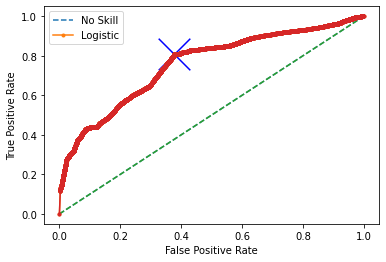

In [457]:
from sklearn.metrics import accuracy_score 
 
from numpy import sqrt
from numpy import argmax
 
# print(accuracy_score(results_gauss , test_labels))
# print(accuracy_score(results_berno , test_labels))


# calculate roc curves
fpr, tpr, thresholds = roc_curve(test_labels, results_gauss)
# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker="x", color='blue', label='Best', s  = 1000)

# show the plot
pyplot.show()


In [458]:
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


print('gaussNB results: ROC_AUC score: ', roc_auc_score(y_true= test_labels, y_score = results_gauss))
print('bernoNB results, ROC_AUC score: ', roc_auc_score(y_true=test_labels, y_score=results_berno))


gaussNB results: ROC_AUC score:  0.758174774772985
bernoNB results, ROC_AUC score:  0.7667764588180879


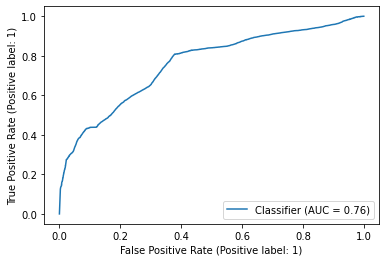

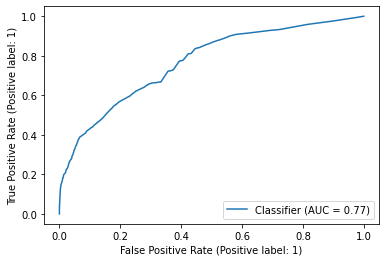

In [459]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(test_labels, y_pred=results_gauss,)
plt.show()
RocCurveDisplay.from_predictions(test_labels, y_pred = results_berno)
plt.show()



In [460]:
# from sklearn.metrics import confusion_matrix
# print('Confusion matrix formatting: \n  True Negative    False Positive \n False Negative      True Positive') 
# print('gaussianNB confusion matrix:\n ', confusion_matrix(test_labels, results_gauss))
# print('BernouilliNB confusion matrix \n', confusion_matrix(test_labels, results_berno))
from sklearn.metrics import classification_report

print(classification_report(test_labels, bnb.predict(test)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     53089
           1       0.48      0.27      0.34      6182

    accuracy                           0.89     59271
   macro avg       0.70      0.62      0.64     59271
weighted avg       0.87      0.89      0.88     59271



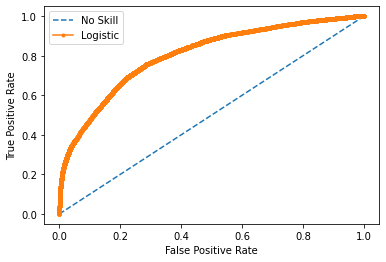

In [461]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

X.time = X.time/max(X.time)
trainX, testX, trainy, testy = train_test_split(
    X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='saga', penalty='l1')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()



random forest classifier: 

In [462]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

forest = RandomForestClassifier(max_depth=2, random_state=0)
forest.fit(X, y)



RandomForestClassifier(max_depth=2, random_state=0)

Assessing precision - recall curve of the classifiers, using F-score

assesing model:  <class 'sklearn.naive_bayes.GaussianNB'>
Best Threshold=0.998538, F-Score=0.397
MATTHEWS CORRELATION COEFF. :  0.3312332928697532


C:\Users\XHK\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


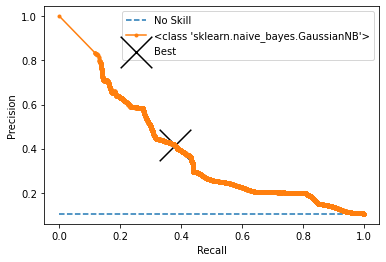

assesing model:  <class 'sklearn.naive_bayes.BernoulliNB'>
Best Threshold=0.262771, F-Score=0.396
MATTHEWS CORRELATION COEFF. :  0.3273509213470972


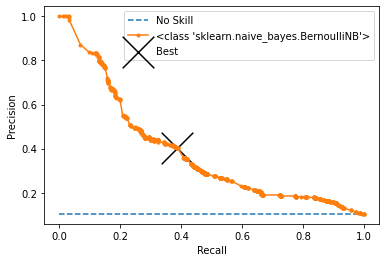

assesing model:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best Threshold=0.219019, F-Score=0.412
MATTHEWS CORRELATION COEFF. :  0.3533561471463208


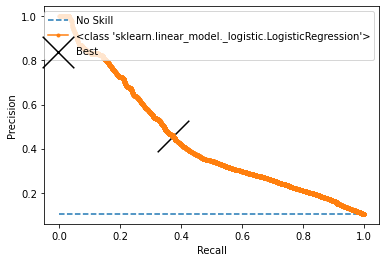

assesing model:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best Threshold=0.142351, F-Score=0.394
MATTHEWS CORRELATION COEFF. :  0.3303257389444076


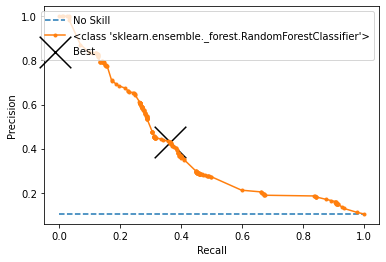

In [464]:

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import fbeta_score
from sklearn.metrics import matthews_corrcoef
# generate dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
#                            n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train, test, train_labels, test_labels
# fit a model
logis = LogisticRegression(solver='saga')
logis.fit(trainX, trainy)

def f_score(model, data = (trainX, testX, trainy, testy)):
    print('assesing model: ', model.__class__)
    trainX, testX, trainy, testy = data
    # predict probabilities
    yhat = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(testy, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    #beta = 2
    #fscore = (1+(beta**2)) * (2 * precision * recall) / \
        #((beta**2) * precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    print(
        f"MATTHEWS CORRELATION COEFF. :  {matthews_corrcoef(testy, yhat>thresholds[ix])}")
    # plot the roc curve for the model
    no_skill = len(testy[testy == 1]) / len(testy)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label=model.__class__)
    pyplot.scatter(recall[ix], precision[ix], marker='x',
                color='black', label='Best',s = 1000)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()
models = [gnb, bnb, logis, forest]
for model in models:
    f_score(model)
    



LogisticRegression model has highest F1-score. At a threshold of 0.219 (i.e. something is classified as a 'goal' if predicted probability of not being a goal is lower than 0.219)

assesing model:  <class 'sklearn.naive_bayes.GaussianNB'>
Best Threshold=0.998549, F-Score=0.391


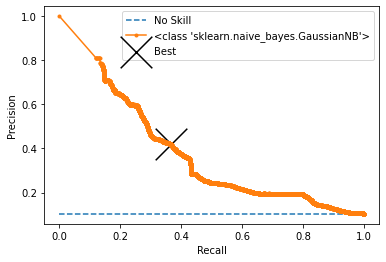

assesing model:  <class 'sklearn.naive_bayes.BernoulliNB'>
Best Threshold=0.262835, F-Score=0.385


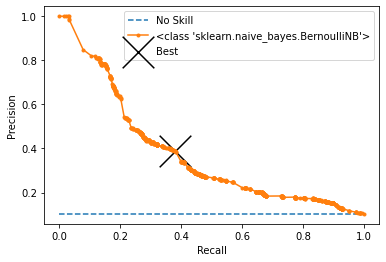

assesing model:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best Threshold=0.191402, F-Score=0.404


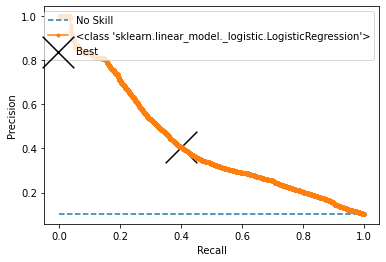

assesing model:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best Threshold=0.139821, F-Score=0.376


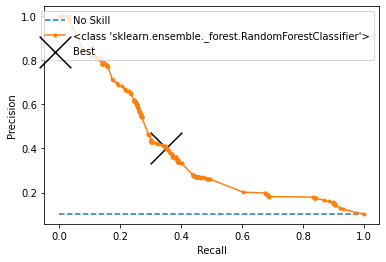

In [ ]:
for model in models:
    f_score(model, data= (trainX, X_fr, trainy, y_fr))


In [ ]:
# X_fr.iloc[argmax(bnb.predict_proba(X_fr)[:,1])]
# top20 = np.argpartition(bnb.predict_proba(X_fr)[:, 1], -20)[-20:]

# french_events.iloc[top20]


Conclusion: 

we can use the Bernoulli classifier to weight the goal-attempts, to get a new 'weighted_attempts' feature. 


In [ ]:
attempt_weighter = bnb

french_events['french_attempt_weight'] =attempt_weighter.predict_proba(X_fr)[:,1]


In [ ]:
#plt.hist(french_events[french_events.is_goal == 1]['french_attempt_weight'].values, bins =50)
bnb.get_params()

{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}

In [ ]:
event_final = pd.concat([events_original, french_events['french_attempt_weight']], axis = 'columns')

#event_final.to_csv('events_w_weighted_french.csv')



In [ ]:
french_events['french_attempt_weight_logistic'] = logis.predict_proba(X_fr)[
    :, 1]

event_final2 = pd.concat(
    [events_original, french_events['french_attempt_weight_logistic']], axis='columns')

event_final2 = event_final2.rename({'french_attempt_weight_logistic' : 'french_attempt_weight'}, axis = 'columns')


In [ ]:
#[i for i in zip(bnb.coef_[0, :], X_fr.columns.values)]
# event_final = pd.concat(
#     [events_original, french_events['french_attempt_weight']], axis='columns')
# sum(event_final['french_attempt_weight'].isna())
french_events
#french_events['french_attempt_weight']

event_final2 = event_final2.rename(
    {'french_attempt_weight_logistic': 'french_attempt_weight'}, axis='columns')

event_final2.to_csv('events_w_weighted_french_logistic.csv')



In [ ]:
import statsmodels
import statsmodels.formula.api as smf
import cvxopt

# X.columns  = [''.join(j) for j in [i.split() for i in X.columns]]   #removes stpaces
 

# Xtrain, Xtest, ytrain, ytest = train_test_split(
#     X, y, test_size=0.33, random_state=20)

# data = pd.concat([Xtrain,ytrain], axis = 'columns')
# test_data = pd.concat([Xtest, ytest], axis='columns')


# log_reg = smf.logit('is_goal ~ ' + '+'.join(Xtrain.columns.values),
#                     data=data).fit_regularized(method='l1')  # .fit(cov_type="hc1")
# #log_reg




Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2648740709873043
            Iterations: 217
            Function evaluations: 217
            Gradient evaluations: 217


In [ ]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(
#     X, y, test_size=0.33, random_state=20)

# '+'.join(Xtrain.columns.values)


# from sklearn.metrics import f1_score
# #print(log_reg.summary())
# y_pred = (log_reg.predict(Xtest) >0.20)

# f1_score(ytest,y_pred)






0.41077030324154756

In [476]:
# print(logis)


LogisticRegression(solver='saga')


In [487]:
from sklearn.model_selection import train_test_split
import random
log_nr = LogisticRegression(fit_intercept=True, penalty="l2")

##Generate 5 distinct random numbers - as random seeds for k test-train splits
k  = 8
randomlist = random.sample(range(1, 10000), k)

##Create features column
coeff_table = pd.DataFrame(X.columns, columns=["features"])

##Assemble coefficients over logistic regression models on 5 random data splits
#iterate over random states while keeping track of `i`
for i, state in enumerate(randomlist):
    train_x, test_x, train_y, test_y = train_test_split(X, y,   stratify=y,
                                                        test_size=0.3, random_state=state)  # 5 test-train splits
    log_nr.fit(train_x, train_y)  # fit logistic model
    coeff_table[f"coefficients_{i+1}"] = np.transpose(log_nr.coef_)

##Calculate mean and std error for model coefficients (from 5 models above)
coeff_table["mean_coeff"] = coeff_table.mean(axis=1)
coeff_table["se_coeff"] = coeff_table.iloc[:, 1:k+1].sem(axis=1)

#Calculate 95% CI intervals for feature coefficients
coeff_table["95ci_se_coeff"] = 1.96*coeff_table["se_coeff"]
coeff_table["coeff_95ci_LL"] = coeff_table["mean_coeff"] - coeff_table["95ci_se_coeff"]
coeff_table["coeff_95ci_UL"] = coeff_table["mean_coeff"] +coeff_table["95ci_se_coeff"]

coeff_table["odds_mean"] = np.exp(coeff_table["mean_coeff"])
coeff_table["95ci_odds_LL"] = np.exp(coeff_table["coeff_95ci_LL"])
coeff_table["95ci_odds_UL"] = np.exp(coeff_table["coeff_95ci_UL"])



C:\Users\XHK\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\XHK\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

coefficients per feature with a k folds CV logistic regression

In [498]:
coefs = coeff_table['features mean_coeff	se_coeff 95ci_se_coeff coeff_95ci_LL coeff_95ci_UL	odds_mean	95ci_odds_LL	95ci_odds_UL'.split()
            ].round(decimals=3)


In [499]:
coefs

,features,mean_coeff,se_coeff,95ci_se_coeff,coeff_95ci_LL,coeff_95ci_UL,odds_mean,95ci_odds_LL,95ci_odds_UL
0,time,0.059,0.008,0.015,0.044,0.074,1.061,1.045,1.077
1,side_Home,0.050,0.004,0.008,0.042,0.058,1.052,1.043,1.060
2,location_Difficult angle and long range,-1.990,0.029,0.057,-2.047,-1.933,0.137,0.129,0.145
3,location_Difficult angle on the left,-1.135,0.011,0.022,-1.157,-1.114,0.321,0.314,0.328
4,location_Difficult angle on the right,-1.095,0.023,0.046,-1.141,-1.049,0.334,0.319,0.350
5,location_Left side of the box,-1.266,0.009,0.018,-1.284,-1.247,0.282,0.277,0.287
6,location_Left side of the six yard box,0.331,0.010,0.020,0.310,0.351,1.392,1.364,1.420
7,location_Long range,-2.448,0.040,0.079,-2.527,-2.370,0.086,0.080,0.094
8,location_More than 35 yards,-2.440,0.031,0.061,-2.502,-2.379,0.087,0.082,0.093
9,location_More than 40 yards,-1.787,0.035,0.069,-1.856,-1.719,0.167,0.156,0.179


In [500]:
coefs.to_csv('weighted_attempts_logistic_coefficients.csv')